Questions:
# College Completion Data: How do institutional characteristics and investment in instruction impact rates of college graduation within a normal time?
# Job Placement Data: How does education level impact job placement rates?

Independent Business Metrics:
# College Completion Data: Gender
# Job Placement Data: Education Level (Academic Percentages)

In [54]:
%pip install pandas numpy scikit-learn matplotlib seaborn


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Completion Pipeline

In [113]:
completion = pd.read_csv('../data/cc_institution_details.csv')


In [57]:
completion.info()

<class 'pandas.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 63 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   index                                 3798 non-null   int64  
 1   unitid                                3798 non-null   int64  
 2   chronname                             3798 non-null   str    
 3   city                                  3798 non-null   str    
 4   state                                 3798 non-null   str    
 5   level                                 3798 non-null   str    
 6   control                               3798 non-null   str    
 7   basic                                 3798 non-null   str    
 8   hbcu                                  94 non-null     str    
 9   flagship                              50 non-null     str    
 10  long_x                                3798 non-null   float64
 11  lat_y                       

# Data Preparation: College Completion

In [59]:
completion_category_cols = ['control', 'level', 'hbcu', 'flagship']
completion[completion_category_cols] = completion[completion_category_cols].astype('category')
completion['exp_award_value'] = pd.to_numeric(completion['exp_award_value'], errors='coerce')
completion['grad_100_value'] = pd.to_numeric(completion['grad_100_value'], errors='coerce')

In [60]:
for col in completion_category_cols:
    print(f"Value counts in '{col}': ")
    print(completion[col].value_counts())
    print("\n")

Value counts in 'control': 
control
Public                    1558
Private not-for-profit    1248
Private for-profit         992
Name: count, dtype: int64


Value counts in 'level': 
level
4-year    2339
2-year    1459
Name: count, dtype: int64


Value counts in 'hbcu': 
hbcu
X    94
Name: count, dtype: int64


Value counts in 'flagship': 
flagship
X    50
Name: count, dtype: int64




In [61]:
completion['hbcu_binary'] = completion['hbcu'].apply(lambda x: 1 if x == 'X' else 0)
completion['flagship_binary'] = completion['flagship'].apply(lambda x: 1 if x == 'X' else 0)

array([[<Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>]], dtype=object)

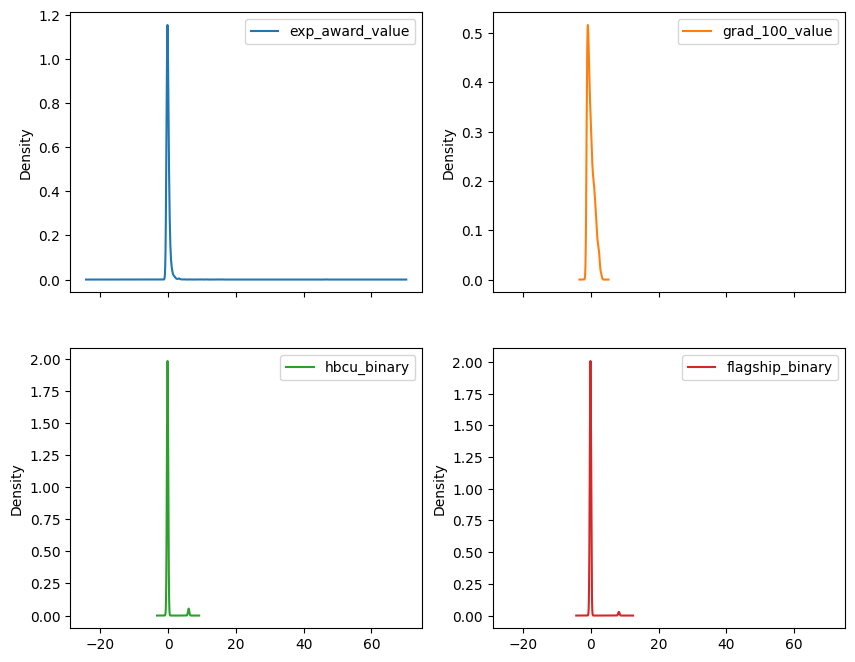

In [62]:
feature_cols = ['exp_award_value', 'grad_100_value', 'hbcu_binary', 'flagship_binary']
completion_clean = completion.dropna(subset=feature_cols)
X = completion_clean[feature_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)
X_scaled_df.plot.density(subplots=True, layout=(2, 2), figsize=(10, 8))

In [63]:
normalizing_scaler = MinMaxScaler().fit_transform(X)
normalizing_scaler[:10]

array([[0.01994114, 0.1       , 1.        , 0.        ],
       [0.02585073, 0.294     , 0.        , 0.        ],
       [0.01105887, 0.        , 0.        , 0.        ],
       [0.01219554, 0.165     , 0.        , 0.        ],
       [0.02506714, 0.088     , 1.        , 0.        ],
       [0.01426517, 0.427     , 0.        , 1.        ],
       [0.01089946, 0.077     , 0.        , 0.        ],
       [0.01108291, 0.099     , 0.        , 0.        ],
       [0.01363077, 0.376     , 0.        , 0.        ],
       [0.0215212 , 0.532     , 0.        , 0.        ]])

In [64]:
category_list = list(X.select_dtypes('category'))
completion_1hot = pd.get_dummies(X, columns=category_list)
completion_1hot

,exp_award_value,grad_100_value,hbcu_binary,flagship_binary
0,105331,10.0,1,0
1,136546,29.4,0,0
2,58414,0.0,0,0
3,64418,16.5,0,0
4,132407,8.8,1,0
...,...,...,...,...
3793,24047,0.0,0,0
3794,105965,51.5,0,0
3795,52936,37.5,0,0
3796,74857,42.1,0,0


In [65]:
median_grad_100_value = completion['grad_100_value'].median()
completion_clean['grad_success'] = (completion_clean['grad_100_value'] >= median_grad_100_value).astype(int)

count    3.467000e+03
mean     6.680864e+04
std      1.117306e+05
min      0.000000e+00
25%      3.277450e+04
50%      5.183700e+04
75%      7.890350e+04
max      5.282095e+06
Name: exp_award_value, dtype: float64

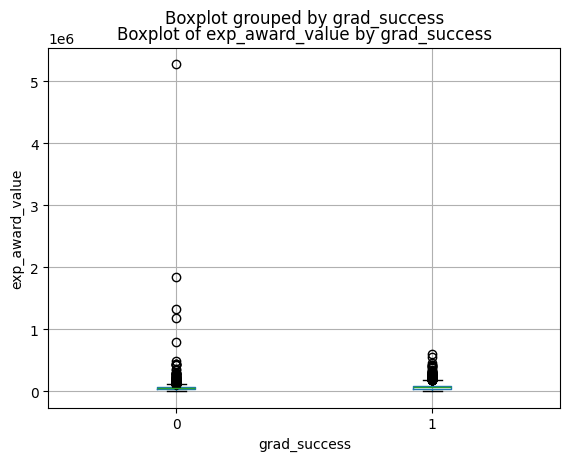

In [78]:
completion_1hot['grad_success'] = completion_clean['grad_success']
completion_1hot.boxplot(column='exp_award_value', by='grad_success')
plt.xlabel('grad_success')
plt.ylabel('exp_award_value')
plt.title('Boxplot of exp_award_value by grad_success')
completion_1hot.exp_award_value.describe()

In [91]:
median_spending_value = completion_1hot['exp_award_value'].median()
completion_1hot['spending_binary'] = pd.cut(completion_1hot['exp_award_value'], bins=[-1, median_spending_value, np.inf], labels=[0, 1])
completion_1hot.head()

,exp_award_value,grad_100_value,hbcu_binary,flagship_binary,grad_success,rating,spending_binary
0,105331,10.0,1,0,0,Top 25%,1
1,136546,29.4,0,0,1,Top 25%,1
2,58414,0.0,0,0,0,High,1
3,64418,16.5,0,0,0,High,1
4,132407,8.8,1,0,0,Top 25%,1


# Prevalence

In [112]:
prevalence = completion_1hot['spending_binary'].value_counts()[1] / len(completion_1hot)
print(f"Prevalence of high spending institutions: {prevalence:.2%}")
manual_prevalence = 1733 / (1733 + 1734)
print(f"Manual prevalence calculation: {manual_prevalence:.2%}")

Prevalence of high spending institutions: 49.99%
Manual prevalence calculation: 49.99%


# Data Partitions

In [110]:
Train, Test = train_test_split(completion_1hot, train_size=0.2, stratify=completion_1hot['grad_success'], random_state=42)
print(f"Train shape: {Train.shape}, Test shape: {Test.shape}")
print("Train Success Prevalence:")
print("Prevalence of 'grad_success' in Train:")
print(Train['grad_success'].mean())
print(Train['grad_success'].value_counts(normalize=True))

Train shape: (693, 7), Test shape: (2774, 7)
Train Success Prevalence:
Prevalence of 'grad_success' in Train:
0.5007215007215007
grad_success
1    0.500722
0    0.499278
Name: proportion, dtype: float64


In [111]:
Tune, Test = train_test_split(Test, test_size=0.5, stratify=Test['grad_success'], random_state=42)
print("Prevalence of 'grad_success' in Tune:")
print(Tune['grad_success'].mean())
print(Tune['grad_success'].value_counts(normalize=True))
print("Prevalence of 'grad_success' in Test:")
print(Test['grad_success'].mean())
print(Test['grad_success'].value_counts(normalize=True))

Prevalence of 'grad_success' in Tune:
0.5010814708002884
grad_success
1    0.501081
0    0.498919
Name: proportion, dtype: float64
Prevalence of 'grad_success' in Test:
0.5010814708002884
grad_success
1    0.501081
0    0.498919
Name: proportion, dtype: float64


# Job Placement Pipeline

In [123]:
placement = pd.read_csv('../data/Placement_Data_Full_Class.csv')
placement.info()

<class 'pandas.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    str    
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    str    
 4   hsc_p           215 non-null    float64
 5   hsc_b           215 non-null    str    
 6   hsc_s           215 non-null    str    
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    str    
 9   workex          215 non-null    str    
 10  etest_p         215 non-null    float64
 11  specialisation  215 non-null    str    
 12  mba_p           215 non-null    float64
 13  status          215 non-null    str    
 14  salary          148 non-null    float64
dtypes: float64(6), int64(1), str(8)
memory usage: 25.3 KB


In [124]:
categorical_cols = ['gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'specialisation']
placement[categorical_cols] = placement[categorical_cols].astype('category')
placement[['ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p']] = placement[['ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p']].astype(float)

In [125]:
top_degrees = ['Comm&Mgmt', 'Sci&Tech']
placement['degree_t'] = placement['degree_t'].apply(lambda x: x if x in top_degrees else 'Other').astype('category')

In [126]:
columns_to_encode = ['gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex', 'specialisation']
placement_1hot = pd.get_dummies(placement, columns=columns_to_encode, drop_first=True)

array([[<Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>]], dtype=object)

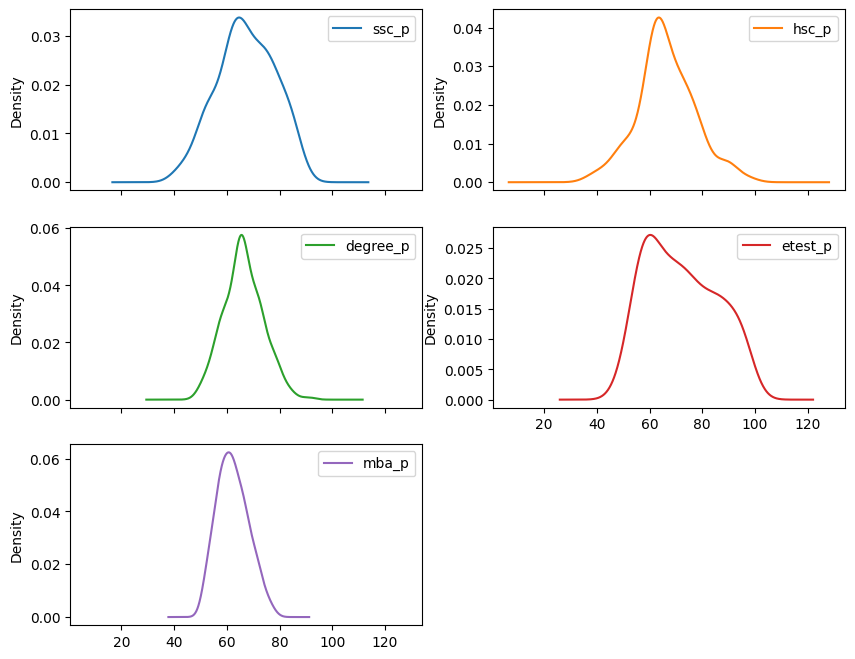

In [132]:
normalization = ['ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p']
scaler_placement = MinMaxScaler().fit_transform(placement_1hot[normalization])
placement_1hot[normalization].plot.density(subplots=True, layout=(3, 2), figsize=(10, 8))

In [133]:
placement_needed_vars = placement_1hot.drop(['sl_no', 'salary'], axis=1, errors='ignore')

In [134]:
placement_needed_vars['target'] = (placement_needed_vars['status'] == 'Placed').astype(int)
placement_needed_vars = placement_needed_vars.drop('status', axis=1)
print(f"Prevalence: {placement_needed_vars['target'].mean():.2%}")
print(placement_needed_vars['target'].value_counts(normalize=True))

Prevalence: 68.84%
target
1    0.688372
0    0.311628
Name: proportion, dtype: float64


Descriptive statistics of degree_p:
count    215.000000
mean      66.370186
std        7.358743
min       50.000000
25%       61.000000
50%       66.000000
75%       72.000000
max       91.000000
Name: degree_p, dtype: float64


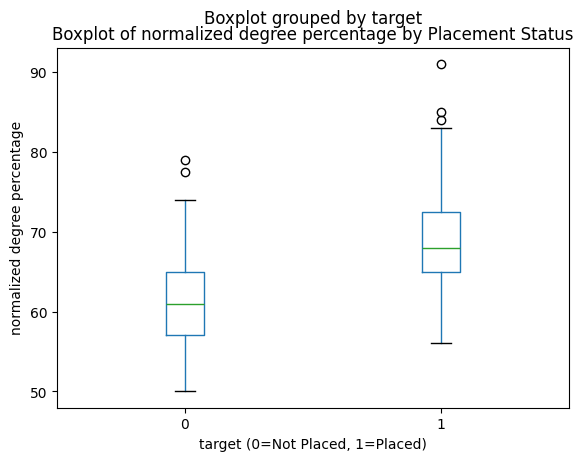

In [136]:
placement_needed_vars.boxplot(column='degree_p', by='target', grid=False)
plt.xlabel('target (0=Not Placed, 1=Placed)')
plt.ylabel('normalized degree percentage')
plt.title('Boxplot of normalized degree percentage by Placement Status')
print("Descriptive statistics of degree_p:")
print(placement_needed_vars['degree_p'].describe())

In [137]:
Train, Test = train_test_split(placement_needed_vars, train_size=0.2, stratify=placement_needed_vars['target'], random_state=42)
Tune, Test = train_test_split(Test, test_size=0.5, stratify=Test['target'], random_state=42)
print(f"Train shape: {Train.shape}, Tune shape: {Tune.shape}, Test shape: {Test.shape}")
print("Check Train Prevalence:")
print(Train['target'].mean())
print(Train['target'].value_counts(normalize=True))
print("Check Tune Prevalence:")
print(Tune['target'].mean())
print(Tune['target'].value_counts(normalize=True))
print("Check Test Prevalence:")
print(Test['target'].mean())
print(Test['target'].value_counts(normalize=True))

Train shape: (43, 15), Tune shape: (86, 15), Test shape: (86, 15)
Check Train Prevalence:
0.6976744186046512
target
1    0.697674
0    0.302326
Name: proportion, dtype: float64
Check Tune Prevalence:
0.686046511627907
target
1    0.686047
0    0.313953
Name: proportion, dtype: float64
Check Test Prevalence:
0.686046511627907
target
1    0.686047
0    0.313953
Name: proportion, dtype: float64


# What My Insticts Tell Me About the Data
I believe that the function and pipelines I created for each of the two datasets will help me to directly address the questions I outlined at the top of this file. However, my greatest worry lies with the possibility that an individual from the Job Placement dataset was hired due to their work experience (workex) rather than their level of education. This variable could greatly influence the results of my analysis. In the future, I could specify my data formatting to only include individuals with no prior work experience to fully understand the relationship between education level and job placement.